
# Fine-Grained Sentiment Analysis with DistilBERT
## SST-5 Dataset (5-class sentiment classification)
 
### **Model**: DistilBERT-base-uncased fine-tuned on SST-5  

## 1. Environment Setup & GPU Verification

In [102]:
# %%
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import sys
import warnings
warnings.filterwarnings('ignore')

try:
    import accelerate
    print(f"accelerate version: {accelerate.__version__}")
except ImportError:
    print("accelerate not found")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    
    # Test tensor operations
    test_tensor = torch.randn(3, 3).to(device)
    print(f"Tensor operations on GPU: {test_tensor.device}")
else:
    print("GPU not available")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Visualization setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Monitoring function
def monitoring_function():
    """Prints current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1e6
        reserved = torch.cuda.memory_reserved(0) / 1e6
        return allocated, reserved
    return 0, 0

accelerate version: 1.10.1
Using device: cuda
GPU Detected: NVIDIA GeForce RTX 3050 Laptop GPU
Memory: 4.29 GB
CUDA Version: 11.8
Tensor operations on GPU: cuda:0



## 2. Load  SST-5 Dataset

In [103]:
# Loading data
from datasets import load_dataset
dataset = load_dataset("SetFit/sst5")
print("\nDataset structure:")
print(dataset)

# Data spliting
print(f"\nTraining samples: {len(dataset['train']):,}")
print(f"Validation samples: {len(dataset['validation']):,}")
print(f"Test samples: {len(dataset['test']):,}")

Repo card metadata block was not found. Setting CardData to empty.



Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})

Training samples: 8,544
Validation samples: 1,101
Test samples: 2,210


In [104]:
# Converting to pandas for exploration
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Label mapping for SST-5
label_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
print("\nLabel mapping:")
for label_id, label_name in label_map.items():
    print(f"{label_id} -> {label_name}")

# Sample training data
print("\nSample training data:")
for i in range(3):
    text = train_df['text'].iloc[i]
    label = train_df['label'].iloc[i]
    label_text = train_df['label_text'].iloc[i]
    print(f"\nSample {i+1}:")
    print(f"Text: {text[:50]}..." if len(text) > 50 else f"Text: {text}")
    print(f"Label: {label}")
    print(f"Label Text: {label_text}")


Label mapping:
0 -> Very Negative
1 -> Negative
2 -> Neutral
3 -> Positive
4 -> Very Positive

Sample training data:

Sample 1:
Text: a stirring , funny and finally transporting re-ima...
Label: 4
Label Text: very positive

Sample 2:
Text: apparently reassembled from the cutting-room floor...
Label: 1
Label Text: negative

Sample 3:
Text: they presume their audience wo n't sit still for a...
Label: 1
Label Text: negative


## 3. DistilBERT Tokenization func

In [105]:
def tokenize_function(examples):
    """Tokenizing text for DistilBERT"""
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128, return_tensors=None)
train_dataset = dataset['train'].map(tokenize_function, batched=True)
val_dataset = dataset['validation'].map(tokenize_function, batched=True)
test_dataset = dataset['test'].map(tokenize_function, batched=True)

# Converting to torch format
def c_to_t_format(dataset):
    """Converting HuggingFace dataset to torch tensors"""
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset
train_dataset = c_to_t_format(train_dataset)
val_dataset = c_to_t_format(val_dataset)
test_dataset = c_to_t_format(test_dataset)

## 4. DistilBERT Model Setup

In [106]:
# Model setup
from transformers import DistilBertForSequenceClassification

# Clearing GPU cache before loading model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU cache cleared")
mem_before = monitoring_function()
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=5,
    id2label={i: label for i, label in label_map.items()},
    label2id={label: i for i, label in label_map.items()},
    ignore_mismatched_sizes=True) 
model.to(device) # Moving model to GPU
mem_after = monitoring_function()
if torch.cuda.is_available():
    print(f"Model loaded. Memory used: {mem_after[0] - mem_before[0]:.1f} MB")
print(f"\nModel loaded successfully!")
model.gradient_checkpointing_enable() # Enabling gradient checkpointing
print("Gradient checkpointing enabled")

GPU cache cleared


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded. Memory used: 270.0 MB

Model loaded successfully!
Gradient checkpointing enabled


## 5. Training Configuration

In [107]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

#  metrics function
def compute_metrics(p):
    """Compute metrics for evaluation"""
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support( p.label_ids, preds, average='weighted', zero_division=0)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Training arguments
training_args = TrainingArguments(
    output_dir='./sst5_distilbert_results',
    overwrite_output_dir=True,
    
    # Training parameters
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    
    # Optimization
    learning_rate=2e-5,
    weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    
    # Memory optimization
    fp16=True,
    gradient_checkpointing=True,
    
    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    
    # Logging
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    
    # Misc
    seed=42,
    data_seed=42,
    report_to="none",
    ddp_find_unused_parameters=False,
    remove_unused_columns=True,
    label_names=["labels"],
)
print("Training configuration:")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Learning rate: {training_args.learning_rate}")

Training configuration:
Batch size: 8
Gradient accumulation: 2
Effective batch size: 16
Epochs: 3
Learning rate: 2e-05


## 6. Model Training

In [108]:
# Initialize Trainer
trainer = Trainer( model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset, compute_metrics=compute_metrics, tokenizer=tokenizer,)

# Clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


train_result = trainer.train() # Training the model
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples per second: {train_result.metrics['train_samples_per_second']:.2f}")


trainer.save_model() # Saving the model
print("Model saved to ./sst5_distilbert_results")

Training samples: 8544
Validation samples: 1101


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.176400,1.153014,0.489555,0.491661,0.489555,0.457284
2,0.976700,1.164263,0.490463,0.484346,0.490463,0.479794
3,0.788500,1.208219,0.484105,0.478339,0.484105,0.476858


Training time: 294.03 seconds
Training samples per second: 87.17
Model saved to ./sst5_distilbert_results


## 7. Model Evaluation

In [109]:
# Model Evalution
print("MODEL EVALUATION\nEvaluating on test set:")
test_metrics = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score: {test_metrics['eval_f1']:.4f}")

# Generating predictions
test_predictions = trainer.predict(test_dataset)
preds = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(true_labels, preds, 
                           target_names=[label_map[i] for i in range(5)],
                           digits=4))

MODEL EVALUATION
Evaluating on test set:


Test Accuracy: 0.5136
Test F1 Score: 0.4845

Classification Report:
               precision    recall  f1-score   support

Very Negative     0.6238    0.2258    0.3316       279
     Negative     0.5344    0.7615    0.6280       633
      Neutral     0.3846    0.1799    0.2452       389
     Positive     0.4567    0.6922    0.5503       510
Very Positive     0.6627    0.4185    0.5131       399

     accuracy                         0.5136      2210
    macro avg     0.5324    0.4556    0.4536      2210
 weighted avg     0.5245    0.5136    0.4845      2210



## 8. Visualizations

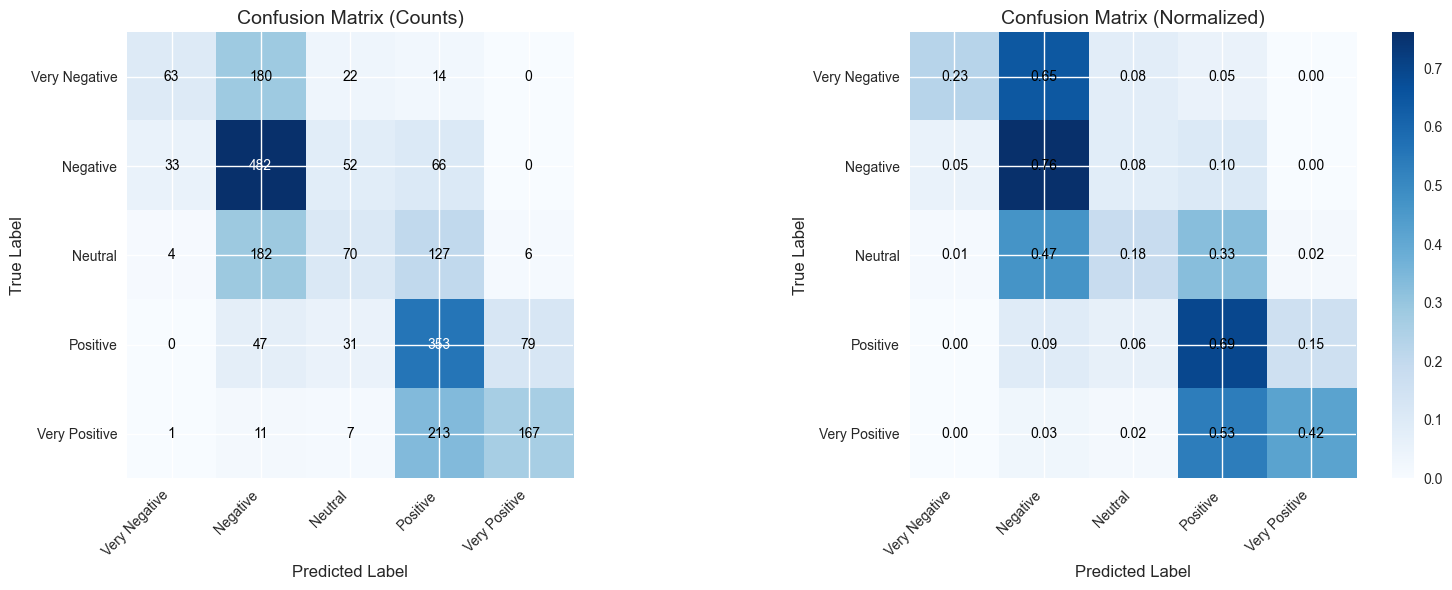

In [110]:
# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
im1 = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14)
axes[0].set_xticks(range(5))
axes[0].set_yticks(range(5))
axes[0].set_xticklabels([label_map[i] for i in range(5)], rotation=45, ha='right')
axes[0].set_yticklabels([label_map[i] for i in range(5)])
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0].text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im2 = axes[1].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14)
axes[1].set_xticks(range(5))
axes[1].set_yticks(range(5))
axes[1].set_xticklabels([label_map[i] for i in range(5)], rotation=45, ha='right')
axes[1].set_yticklabels([label_map[i] for i in range(5)])
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        axes[1].text(j, i, format(cm_normalized[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()

## 9. Save Model

In [111]:
# Saving final model
os.makedirs('./deployment_model', exist_ok=True)
model.save_pretrained('./deployment_model')
tokenizer.save_pretrained('./deployment_model')
print("Model saved to ./deployment_model/")

Model saved to ./deployment_model/


## 10. Summary

In [112]:
# Summary
print("PROJECT SUMMARY")
print(f"\nModel Performance:")
print(f"Test Accuracy: {test_metrics['eval_accuracy']:.4f}")
print(f"Test F1 Score: {test_metrics['eval_f1']:.4f}")
print(f"\nTraining Details:")
print(f"Training Time: {train_result.metrics['train_runtime']/60:.1f} minutes")
print(f"Final Loss: {train_result.metrics['train_loss']:.4f}")

PROJECT SUMMARY

Model Performance:
Test Accuracy: 0.5136
Test F1 Score: 0.4845

Training Details:
Training Time: 4.9 minutes
Final Loss: 1.0314
